# MT3DMS Example Problems

The purpose of this notebook is to recreate the example problems that are described in the 1999 MT3DMS report.

There are 10 example problems:
1. One-Dimensional Transport in a Uniform Flow Field
2. One-Dimensional Transport with Nonlinear or Nonequilibrium Sorption
3. Two-Dimensional Transport in a Uniform Flow Field
4. Two-Dimensional Transport in a Diagonal Flow Field
5. Two-Dimensional Transport in a Radial Flow Field
6. Concentration at an Injection/Extraction Well
7. Three-Dimensional Transport in a Uniform Flow Field
8. Two-Dimensional, Vertical Transport in a Heterogeneous Aquifer
9. Two-Dimensional Application Example
10. Three-Dimensional Field Case Study

In [1]:
import os
import sys

In [2]:
from pathlib import Path
from pprint import pformat
from tempfile import TemporaryDirectory

import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pooch

import flopy
from flopy.utils.util_array import read1d

mpl.rcParams["figure.figsize"] = (8, 8)

exe_name_mf = "mf2005"
exe_name_mt = "mt3dms"

# temporary directory
temp_dir = TemporaryDirectory()
workdir = temp_dir.name

print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")

# Check if we are in the repository and define the data path.

try:
    root = Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None

data_path = root / "examples" / "data" if root else Path.cwd()
datadir = data_path / "mt3d_test" / "mt3dms"

file_names = {
    "p08shead.dat": None,
    "p10cinit.dat": None,
    "p10shead.dat": None,
}
for fname, fhash in file_names.items():
    pooch.retrieve(
        url=f"https://github.com/modflowpy/flopy/raw/develop/examples/data/mt3d_test/mt3dms/{fname}",
        fname=fname,
        path=data_path / "mt3d_test" / "mt3dms",
        known_hash=None,
    )


3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]
numpy version: 2.1.0
matplotlib version: 3.9.2
flopy version: 3.9.2


SHA256 hash of downloaded file: 4355f6955d0a3cc8ab770a272cec71ed5a90e03bacdbaea3b217d8ccb5e62202
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 85d46994fe49fc15a99379ffbc99ec04e26a475b1f92098f9449b2f7fc4addfd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 0c03116d4e415075a203a14a0bae86b16d748969027eba131afd8814c99acf93
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


## Example 1. One-Dimensional Transport in a Uniform Flow Field

This example has 4 cases:
* Case 1a: Advection only
* Case 1b: Advection and dispersion
* Case 1c: Advection, dispersion, and sorption
* Case 1d: Advection, dispersion, sorption, and decay

In [3]:
def p01(dirname, al, retardation, lambda1, mixelm):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 1
    ncol = 101
    delr = 10
    delc = 1
    delv = 1
    Lx = (ncol - 1) * delr
    v = 0.24
    prsity = 0.25
    q = v * prsity

    perlen = 2000.0
    hk = 1.0
    laytyp = 0
    rhob = 0.25
    kd = (retardation - 1.0) * prsity / rhob

    modelname_mf = f"{dirname}_mf"
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf
    )
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=0.0,
        botm=[0 - delv],
        perlen=perlen,
    )
    ibound = np.ones((nlay, nrow, ncol), dtype=int)
    ibound[0, 0, 0] = -1
    ibound[0, 0, -1] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=float)
    h1 = q * Lx
    strt[0, 0, 0] = h1
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    success, buff = mf.run_model(silent=True, report=True)
    assert success, pformat(buff)

    modelname_mt = f"{dirname}_mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=model_ws,
        exe_name=exe_name_mt,
        modflowmodel=mf,
    )
    c0 = 1.0
    icbund = np.ones((nlay, nrow, ncol), dtype=int)
    icbund[0, 0, 0] = -1
    sconc = np.zeros((nlay, nrow, ncol), dtype=float)
    sconc[0, 0, 0] = c0
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc)
    dceps = 1.0e-5
    nplane = 1
    npl = 0
    nph = 4
    npmin = 0
    npmax = 8
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=0.5,
    )
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al)
    rct = flopy.mt3d.Mt3dRct(
        mt,
        isothm=1,
        ireact=1,
        igetsc=0,
        rhob=rhob,
        sp1=kd,
        rc1=lambda1,
        rc2=lambda1,
    )
    ssm = flopy.mt3d.Mt3dSsm(mt)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)

    fname = os.path.join(model_ws, "MT3D001.UCN")
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, "MT3D001.MAS")
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

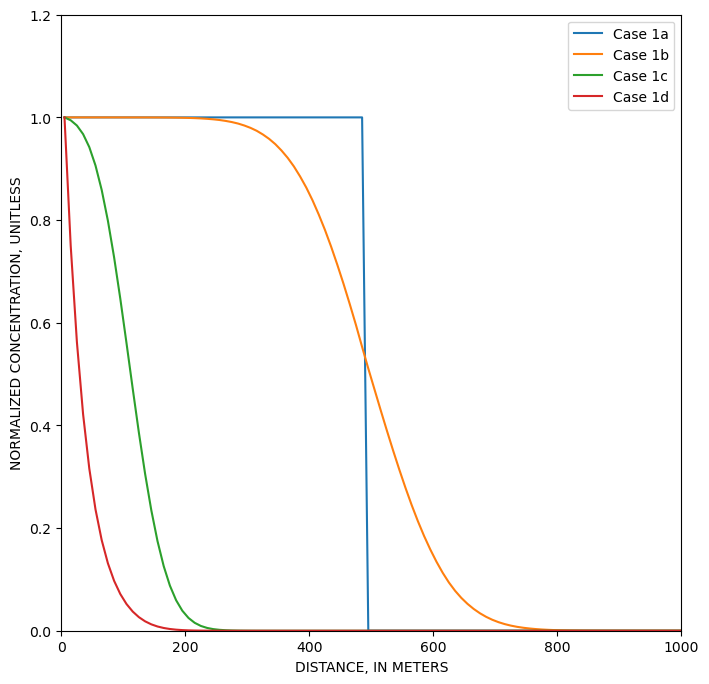

In [4]:
mf, mt, conc, cvt, mvt = p01("case1a", 0, 1, 0, 1)
x = mf.modelgrid.xcellcenters.ravel()
y = conc[0, 0, 0, :]
plt.plot(x, y, label="Case 1a")

mf, mt, conc, cvt, mvt = p01("case1b", 10, 1, 0, 1)
y = conc[0, 0, 0, :]
plt.plot(x, y, label="Case 1b")

mf, mt, conc, cvt, mvt = p01("case1c", 10, 5, 0, 2)
y = conc[0, 0, 0, :]
plt.plot(x, y, label="Case 1c")

mf, mt, conc, cvt, mvt = p01("case1d", 10, 5, 0.002, 2)
y = conc[0, 0, 0, :]
plt.plot(x, y, label="Case 1d")

plt.xlim(0, 1000)
plt.ylim(0, 1.2)
plt.xlabel("DISTANCE, IN METERS")
plt.ylabel("NORMALIZED CONCENTRATION, UNITLESS")
plt.legend()

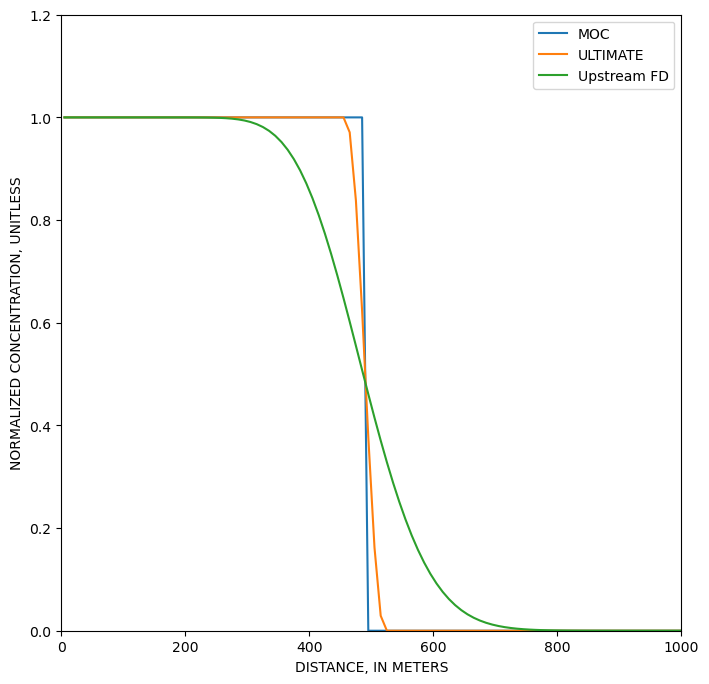

In [5]:
mf, mt, conc, cvt, mvt = p01("case1e", 0, 1, 0, 1)
y = conc[0, 0, 0, :]
plt.plot(x, y, label="MOC")

mf, mt, conc, cvt, mvt = p01("case1f", 0, 1, 0, -1)
y = conc[0, 0, 0, :]
plt.plot(x, y, label="ULTIMATE")

mf, mt, conc, cvt, mvt = p01("case1g", 0, 1, 0, 0)
y = conc[0, 0, 0, :]
plt.plot(x, y, label="Upstream FD")

plt.xlim(0, 1000)
plt.ylim(0, 1.2)
plt.xlabel("DISTANCE, IN METERS")
plt.ylabel("NORMALIZED CONCENTRATION, UNITLESS")
plt.legend()

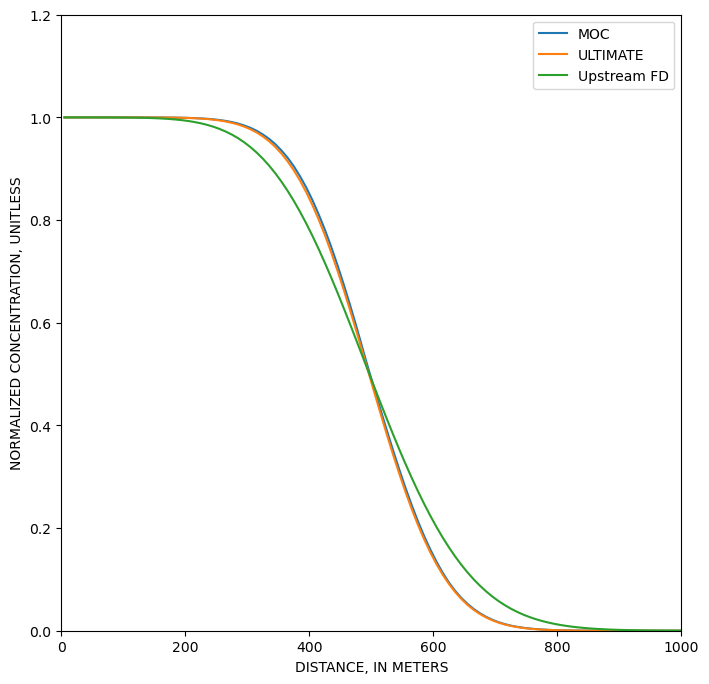

In [6]:
mf, mt, conc, cvt, mvt = p01("case1e", 10, 1, 0, 1)
y = conc[0, 0, 0, :]
plt.plot(x, y, label="MOC")

mf, mt, conc, cvt, mvt = p01("case1f", 10, 1, 0, -1)
y = conc[0, 0, 0, :]
plt.plot(x, y, label="ULTIMATE")

mf, mt, conc, cvt, mvt = p01("case1g", 10, 1, 0, 0)
y = conc[0, 0, 0, :]
plt.plot(x, y, label="Upstream FD")

plt.xlim(0, 1000)
plt.ylim(0, 1.2)
plt.xlabel("DISTANCE, IN METERS")
plt.ylabel("NORMALIZED CONCENTRATION, UNITLESS")
plt.legend()

## Example 2. One-Dimensional Transport with Nonlinear or Nonequilibrium Sorption

In [7]:
def p02(dirname, isothm, sp1, sp2, mixelm):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 1
    ncol = 101
    delr = 0.16
    delc = 1
    delv = 1
    Lx = (ncol - 1) * delr
    v = 0.1
    prsity = 0.37
    q = v * prsity

    perlen_mf = 1.0
    perlen_mt = [160, 1320]
    hk = 1.0
    laytyp = 0
    rhob = 1.587

    modelname_mf = f"{dirname}_mf"
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf
    )
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=0.0,
        botm=[0 - delv],
        perlen=perlen_mf,
    )
    ibound = np.ones((nlay, nrow, ncol), dtype=int)
    ibound[0, 0, 0] = -1
    ibound[0, 0, -1] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=float)
    h1 = q * Lx
    strt[0, 0, 0] = h1
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = f"{dirname}_mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=model_ws,
        exe_name=exe_name_mt,
        modflowmodel=mf,
    )
    btn = flopy.mt3d.Mt3dBtn(
        mt,
        icbund=1,
        prsity=prsity,
        sconc=0,
        nper=2,
        perlen=perlen_mt,
        obs=[(0, 0, 50)],
    )
    dceps = 1.0e-5
    nplane = 1
    npl = 0
    nph = 4
    npmin = 0
    npmax = 8
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=0.5,
    )
    al = 1.0
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al)
    rct = flopy.mt3d.Mt3dRct(
        mt, isothm=isothm, ireact=0, igetsc=0, rhob=rhob, sp1=sp1, sp2=sp2
    )
    c0 = 0.05
    spd = {0: [0, 0, 0, c0, 1], 1: [0, 0, 0, 0.0, 1]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)

    fname = os.path.join(model_ws, "MT3D001.UCN")
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, "MT3D001.MAS")
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

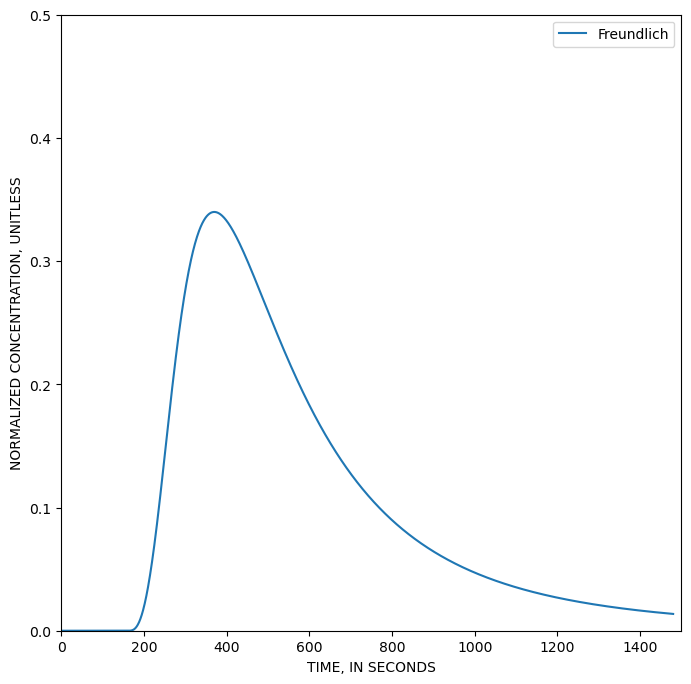

In [8]:
mf, mt, conc, cvt, mvt = p02("freundlich", 2, 0.3, 0.7, -1)
x = cvt["time"]
y = cvt["(1, 1, 51)"] / 0.05
plt.plot(x, y, label="Freundlich")
plt.xlim(0, 1500)
plt.ylim(0, 0.5)
plt.xlabel("TIME, IN SECONDS")
plt.ylabel("NORMALIZED CONCENTRATION, UNITLESS")
plt.legend()

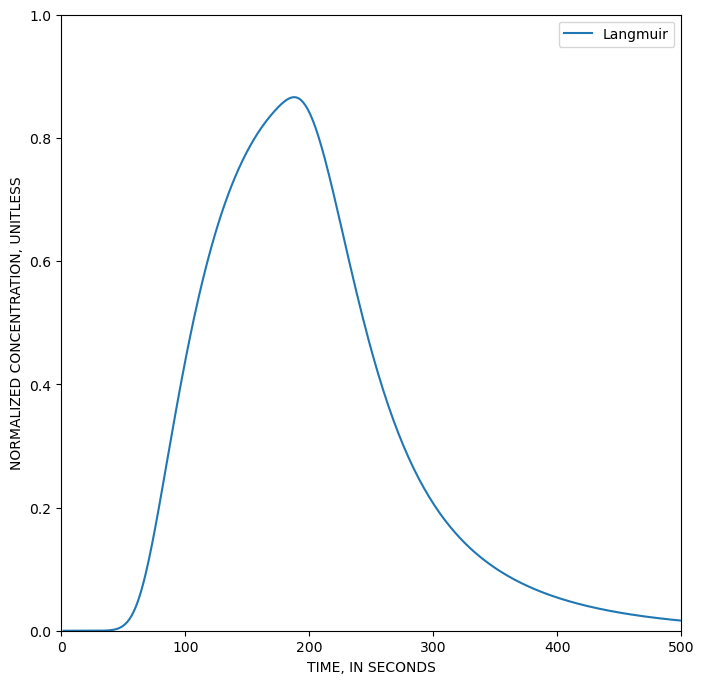

In [9]:
mf, mt, conc, cvt, mvt = p02("langmuir", 3, 100.0, 0.003, -1)
x = cvt["time"]
y = cvt["(1, 1, 51)"] / 0.05
plt.plot(x, y, label="Langmuir")
plt.xlim(0, 500)
plt.ylim(0, 1.0)
plt.xlabel("TIME, IN SECONDS")
plt.ylabel("NORMALIZED CONCENTRATION, UNITLESS")
plt.legend()

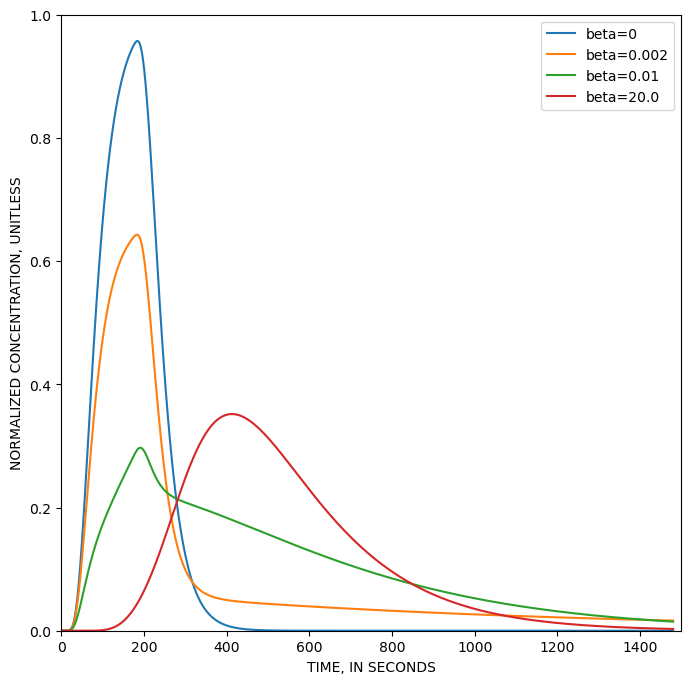

In [10]:
for beta in [0, 2.0e-3, 1.0e-2, 20.0]:
    lbl = f"beta={beta}"
    mf, mt, conc, cvt, mvt = p02("nonequilibrium", 4, 0.933, beta, -1)
    x = cvt["time"]
    y = cvt["(1, 1, 51)"] / 0.05
    plt.plot(x, y, label=lbl)
plt.xlim(0, 1500)
plt.ylim(0, 1.0)
plt.xlabel("TIME, IN SECONDS")
plt.ylabel("NORMALIZED CONCENTRATION, UNITLESS")
plt.legend()

## Example 3. Two-Dimensional Transport in a Uniform Flow Field

In [11]:
def p03(dirname, mixelm):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 31
    ncol = 46
    delr = 10
    delc = 10
    delv = 10
    Lx = (ncol - 1) * delr
    v = 1.0 / 3.0
    prsity = 0.3
    q = v * prsity
    al = 10.0
    trpt = 0.3
    q0 = 1.0
    c0 = 1000.0

    perlen_mf = 365.0
    perlen_mt = 365.0
    hk = 1.0
    laytyp = 0

    modelname_mf = f"{dirname}_mf"
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf
    )
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=0.0,
        botm=[0 - delv],
        perlen=perlen_mf,
    )
    ibound = np.ones((nlay, nrow, ncol), dtype=int)
    ibound[0, :, 0] = -1
    ibound[0, :, -1] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=float)
    h1 = q * Lx
    strt[0, :, 0] = h1
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=[[0, 15, 15, q0]])
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = f"{dirname}_mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=model_ws,
        exe_name=exe_name_mt,
        modflowmodel=mf,
    )
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=0)
    dceps = 1.0e-5
    nplane = 1
    npl = 0
    nph = 16
    npmin = 2
    npmax = 32
    dchmoc = 1.0e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=0.5,
    )
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    spd = {0: [0, 15, 15, c0, 2]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)

    fname = os.path.join(model_ws, "MT3D001.UCN")
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, "MT3D001.MAS")
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

Text(0.5, 1.0, 'HMOC')

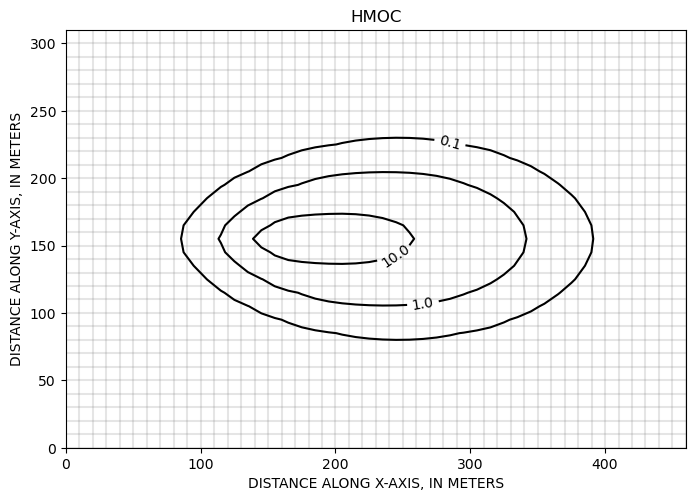

In [12]:
ax = plt.subplot(1, 1, 1, aspect="equal")
mf, mt, conc, cvt, mvt = p03("p03", 3)
conc = conc[0, :, :, :]
pmv = flopy.plot.PlotMapView(model=mf)
pmv.plot_grid(color=".5", alpha=0.2)
cs = pmv.contour_array(conc, levels=[0.1, 1.0, 10.0, 50.0], colors="k")
plt.clabel(cs)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title("HMOC")

Text(0.5, 1.0, 'ULTIMATE')

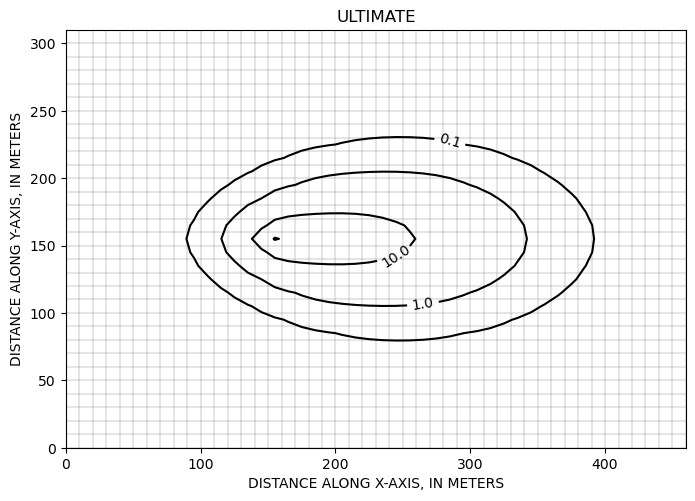

In [13]:
ax = plt.subplot(1, 1, 1, aspect="equal")
mf, mt, conc, cvt, mvt = p03("p03", -1)
conc = conc[0, :, :, :]
pmv = flopy.plot.PlotMapView(model=mf)
pmv.plot_grid(color=".5", alpha=0.2)
cs = pmv.contour_array(conc, levels=[0.1, 1.0, 10.0, 50.0], colors="k")
plt.clabel(cs)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title("ULTIMATE")

## Example 4. Two-Dimensional Transport in a Diagonal Flow Field

In [14]:
def p04(dirname, mixelm):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 100
    ncol = 100
    delr = 10
    delc = 10
    delv = 1
    Lx = (ncol - 1) * delr
    Ly = (nrow - 1) * delc
    Ls = np.sqrt(Lx**2 + Ly**2)
    v = 1.0
    prsity = 0.14
    q = v * prsity
    al = 2.0
    trpt = 0.1
    q0 = 0.01
    c0 = 1000.0

    perlen_mf = 1000.0
    perlen_mt = 1000.0
    hk = 1.0
    laytyp = 0

    modelname_mf = f"{dirname}_mf"
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf
    )
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=0.0,
        botm=[0 - delv],
        perlen=perlen_mf,
    )
    ibound = np.ones((nlay, nrow, ncol), dtype=int) * -1
    ibound[:, 1 : nrow - 1, 1 : ncol - 1] = 1

    # set strt as a linear gradient at a 45 degree angle
    h1 = q * Ls
    x = mf.modelgrid.xcellcenters
    y = mf.modelgrid.ycellcenters
    a = -1
    b = -1
    c = 1
    d = abs(a * x + b * y + c) / np.sqrt(2)
    strt = h1 - d / Ls * h1

    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=[[0, 79, 20, q0]])
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = f"{dirname}_mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=model_ws,
        exe_name=exe_name_mt,
        modflowmodel=mf,
    )
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=0)
    dceps = 1.0e-5
    nplane = 1
    npl = 0
    nph = 16
    npmin = 2
    npmax = 32
    dchmoc = 1.0e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=0.5,
    )
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    spd = {0: [0, 79, 20, c0, 2]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)

    fname = os.path.join(model_ws, "MT3D001.UCN")
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, "MT3D001.MAS")
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

Text(0.5, 1.0, 'MOC')

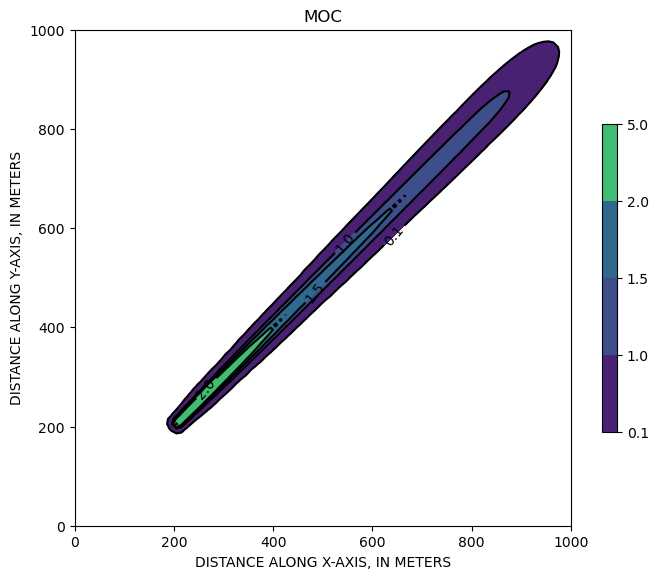

In [15]:
ax = plt.subplot(1, 1, 1, aspect="equal")
mf, mt, conc, cvt, mvt = p04("p04", 1)
grid = mf.modelgrid
conc = conc[0, :, :, :]
levels = [0.1, 1.0, 1.5, 2.0, 5.0]
pmv = flopy.plot.PlotMapView(model=mf)
cf = plt.contourf(grid.xcellcenters, grid.ycellcenters, conc[0], levels=levels)
plt.colorbar(cf, shrink=0.5)
cs = pmv.contour_array(conc, levels=levels, colors="k")
plt.clabel(cs)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title("MOC")

Text(0.5, 1.0, 'Upstream FD')

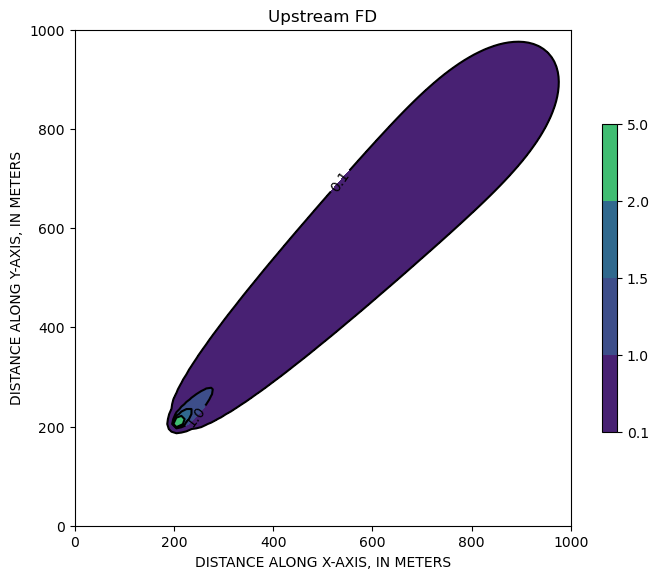

In [16]:
ax = plt.subplot(1, 1, 1, aspect="equal")
mf, mt, conc, cvt, mvt = p04("p04", 0)
grid = mf.modelgrid
conc = conc[0, :, :, :]
levels = [0.1, 1.0, 1.5, 2.0, 5.0]
pmv = flopy.plot.PlotMapView(model=mf)
cf = plt.contourf(grid.xcellcenters, grid.ycellcenters, conc[0], levels=levels)
plt.colorbar(cf, shrink=0.5)
cs = pmv.contour_array(conc, levels=levels, colors="k")
plt.clabel(cs)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title("Upstream FD")

Text(0.5, 1.0, 'ULTIMATE')

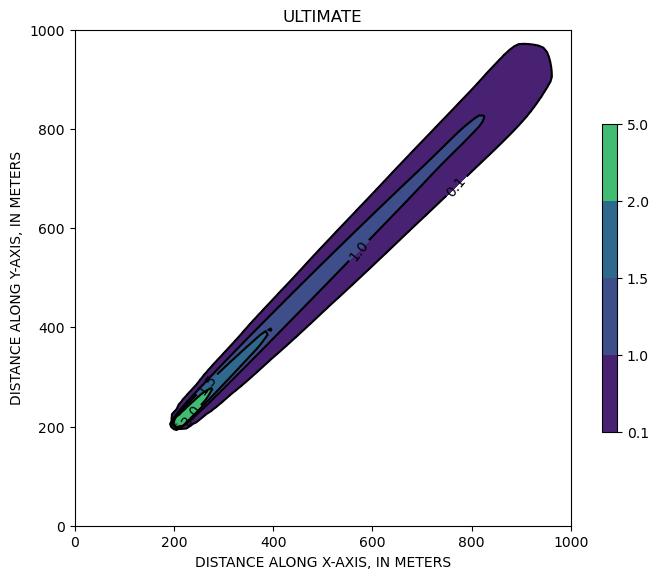

In [17]:
ax = plt.subplot(1, 1, 1, aspect="equal")
mf, mt, conc, cvt, mvt = p04("p04", -1)
grid = mf.modelgrid
conc = conc[0, :, :, :]
levels = [0.1, 1.0, 1.5, 2.0, 5.0]
pmv = flopy.plot.PlotMapView(model=mf)
cf = plt.contourf(grid.xcellcenters, grid.ycellcenters, conc[0], levels=levels)
plt.colorbar(cf, shrink=0.5)
cs = pmv.contour_array(conc, levels=levels, colors="k")
plt.clabel(cs)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title("ULTIMATE")

## Example 5. Two-Dimensional Transport in a Radial Flow Field

In [18]:
def p05(dirname, mixelm, dt0, ttsmult):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 31
    ncol = 31
    delr = 10
    delc = 10
    delv = 1
    prsity = 0.30
    al = 10.0
    trpt = 1.0
    q0 = 100.0
    c0 = 1.0

    perlen_mf = 27.0
    perlen_mt = 27.0
    hk = 1.0
    laytyp = 0

    modelname_mf = f"{dirname}_mf"
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf
    )
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=0.0,
        botm=[0 - delv],
        perlen=perlen_mf,
    )
    ibound = np.ones((nlay, nrow, ncol), dtype=int) * -1
    ibound[:, 1 : nrow - 1, 1 : ncol - 1] = 1
    strt = 0.0

    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=[[0, 15, 15, q0]])
    sip = flopy.modflow.ModflowSip(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = f"{dirname}_mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=model_ws,
        exe_name=exe_name_mt,
        modflowmodel=mf,
    )
    btn = flopy.mt3d.Mt3dBtn(
        mt, icbund=1, prsity=prsity, sconc=0, dt0=dt0, ttsmult=ttsmult
    )
    dceps = 1.0e-5
    nplane = 1
    npl = 0
    nph = 16
    npmin = 2
    npmax = 32
    dchmoc = 1.0e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=0.5,
    )
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    spd = {0: [0, 15, 15, c0, -1]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)

    fname = os.path.join(model_ws, "MT3D001.UCN")
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, "MT3D001.MAS")
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

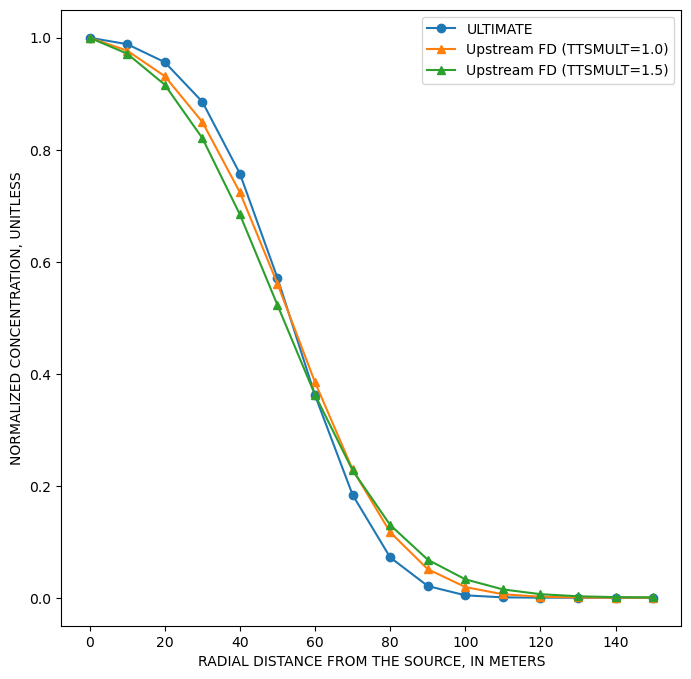

In [19]:
mf, mt, conc, cvt, mvt = p05("p05", -1, 0.3, 1.0)
grid = mf.modelgrid
conc = conc[0, 0, :, :]
x = grid.xcellcenters[15, 15:] - grid.xcellcenters[15, 15]
y = conc[15, 15:]
plt.plot(x, y, label="ULTIMATE", marker="o")

mf, mt, conc, cvt, mvt = p05("p05", 0, 0.3, 1.0)
conc = conc[0, 0, :, :]
x = grid.xcellcenters[15, 15:] - grid.xcellcenters[15, 15]
y = conc[15, 15:]
plt.plot(x, y, label="Upstream FD (TTSMULT=1.0)", marker="^")

mf, mt, conc, cvt, mvt = p05("p05", 0, 0.3, 1.5)
conc = conc[0, 0, :, :]
x = grid.xcellcenters[15, 15:] - grid.xcellcenters[15, 15]
y = conc[15, 15:]
plt.plot(x, y, label="Upstream FD (TTSMULT=1.5)", marker="^")

plt.xlabel("RADIAL DISTANCE FROM THE SOURCE, IN METERS")
plt.ylabel("NORMALIZED CONCENTRATION, UNITLESS")
plt.legend()

Text(0.5, 1.0, 'ULTIMATE')

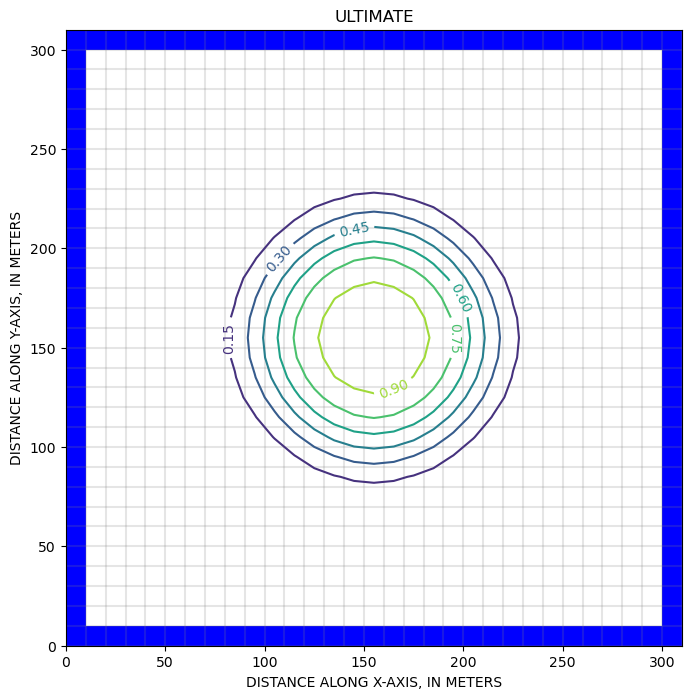

In [20]:
ax = plt.subplot(1, 1, 1, aspect="equal")
mf, mt, conc, cvt, mvt = p05("p05", -1, 0.3, 1.0)
pmv = flopy.plot.PlotMapView(model=mf)
pmv.plot_grid(color=".5", alpha=0.2)
pmv.plot_ibound()
cs = pmv.contour_array(conc[0])
plt.clabel(cs)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title("ULTIMATE")

## Example 6. Concentration at an Injection/Extraction Well

In [21]:
def p06(dirname, mixelm, dt0):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 31
    ncol = 31
    delr = 900
    delc = 900
    delv = 20
    prsity = 0.30
    al = 100.0
    trpt = 1.0
    q0 = 86400.0
    c0 = 100.0

    perlen_mf = [912.5, 2737.5]
    perlen_mt = perlen_mf
    hk = 0.005 * 86400
    laytyp = 0

    modelname_mf = f"{dirname}_mf"
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf
    )
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=0.0,
        botm=[0 - delv],
        nper=2,
        perlen=perlen_mf,
    )
    ibound = np.ones((nlay, nrow, ncol), dtype=int) * -1
    ibound[:, 1 : nrow - 1, 1 : ncol - 1] = 1
    strt = 0.0

    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    welspd = {0: [[0, 15, 15, q0]], 1: [[0, 15, 15, -q0]]}
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    sip = flopy.modflow.ModflowSip(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = f"{dirname}_mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=model_ws,
        exe_name=exe_name_mt,
        modflowmodel=mf,
    )
    btn = flopy.mt3d.Mt3dBtn(
        mt,
        icbund=1,
        prsity=prsity,
        sconc=0,
        nper=2,
        perlen=perlen_mt,
        dt0=dt0,
        obs=[(0, 15, 15)],
    )
    dceps = 1.0e-5
    nplane = 1
    npl = 16
    nph = 16
    npmin = 4
    npmax = 32
    dchmoc = 1.0e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=0.5,
    )
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    spd = {0: [0, 15, 15, c0, 2], 1: [0, 15, 15, 0.0, 2]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)

    fname = os.path.join(model_ws, "MT3D001.UCN")
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, "MT3D001.MAS")
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

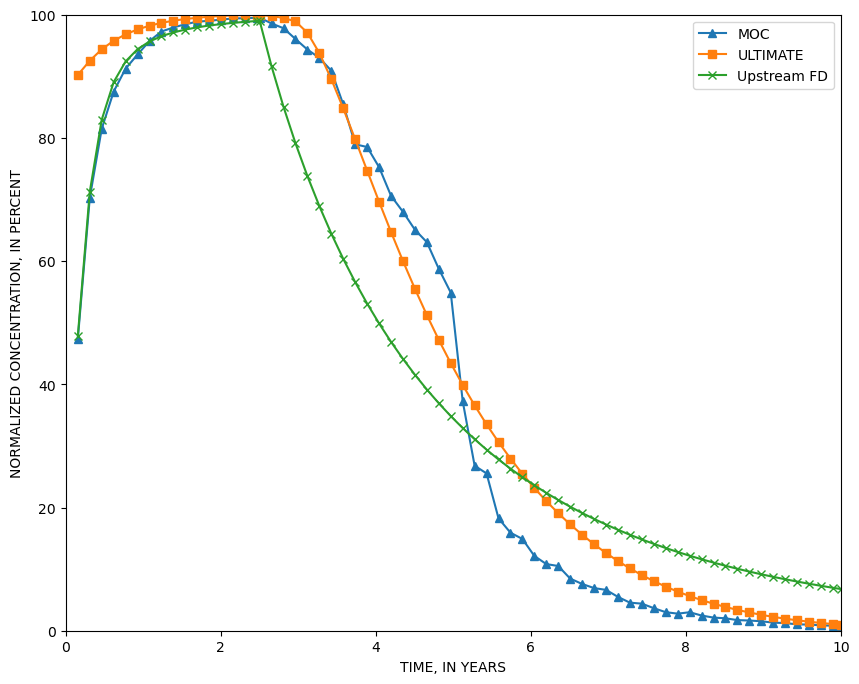

In [22]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
mf, mt, conc, cvt, mvt = p06("p06", 1, 56.25)
x = cvt["time"] / 365.0
y = cvt["(1, 16, 16)"]
ax.plot(x, y, label="MOC", marker="^")

mf, mt, conc, cvt, mvt = p06("p06", -1, 56.25)
x = cvt["time"] / 365.0
y = cvt["(1, 16, 16)"]
ax.plot(x, y, label="ULTIMATE", marker="s")

mf, mt, conc, cvt, mvt = p06("p06", 0, 56.25)
x = cvt["time"] / 365.0
y = cvt["(1, 16, 16)"]
ax.plot(x, y, label="Upstream FD", marker="x")

plt.xlim(0, 10)
plt.ylim(0, 100.0)
plt.xlabel("TIME, IN YEARS")
plt.ylabel("NORMALIZED CONCENTRATION, IN PERCENT")
plt.legend()

## Example 7. Three-Dimensional Transport in a Uniform Flow Field

In [23]:
def p07(dirname, mixelm):
    model_ws = os.path.join(workdir, dirname)
    nlay = 8
    nrow = 15
    ncol = 21
    delr = 10
    delc = 10
    delv = 10
    Lx = (ncol - 1) * delr
    v = 1.0 / 3.0
    prsity = 0.2
    q = v * prsity
    al = 10.0
    trpt = 0.3
    trpv = 0.3
    q0 = 0.5
    c0 = 100.0

    perlen_mf = 100.0
    perlen_mt = 100.0
    hk = 0.5
    laytyp = 0

    modelname_mf = f"{dirname}_mf"
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf
    )
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=0.0,
        botm=[-delv * k for k in range(1, nlay + 1)],
        perlen=perlen_mf,
    )
    ibound = np.ones((nlay, nrow, ncol), dtype=int)
    ibound[:, :, 0] = -1
    ibound[:, :, -1] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=float)
    h1 = q * Lx
    strt[:, :, 0] = h1
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=[[6, 7, 2, q0]])
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = f"{dirname}_mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=model_ws,
        exe_name=exe_name_mt,
        modflowmodel=mf,
    )
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=0)
    dceps = 1.0e-5
    nplane = 1
    npl = 0
    nph = 16
    npmin = 2
    npmax = 32
    dchmoc = 1.0e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=0.5,
    )
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, trpv=trpv)
    spd = {0: [6, 7, 2, c0, 2]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)

    fname = os.path.join(model_ws, "MT3D001.UCN")
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, "MT3D001.MAS")
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

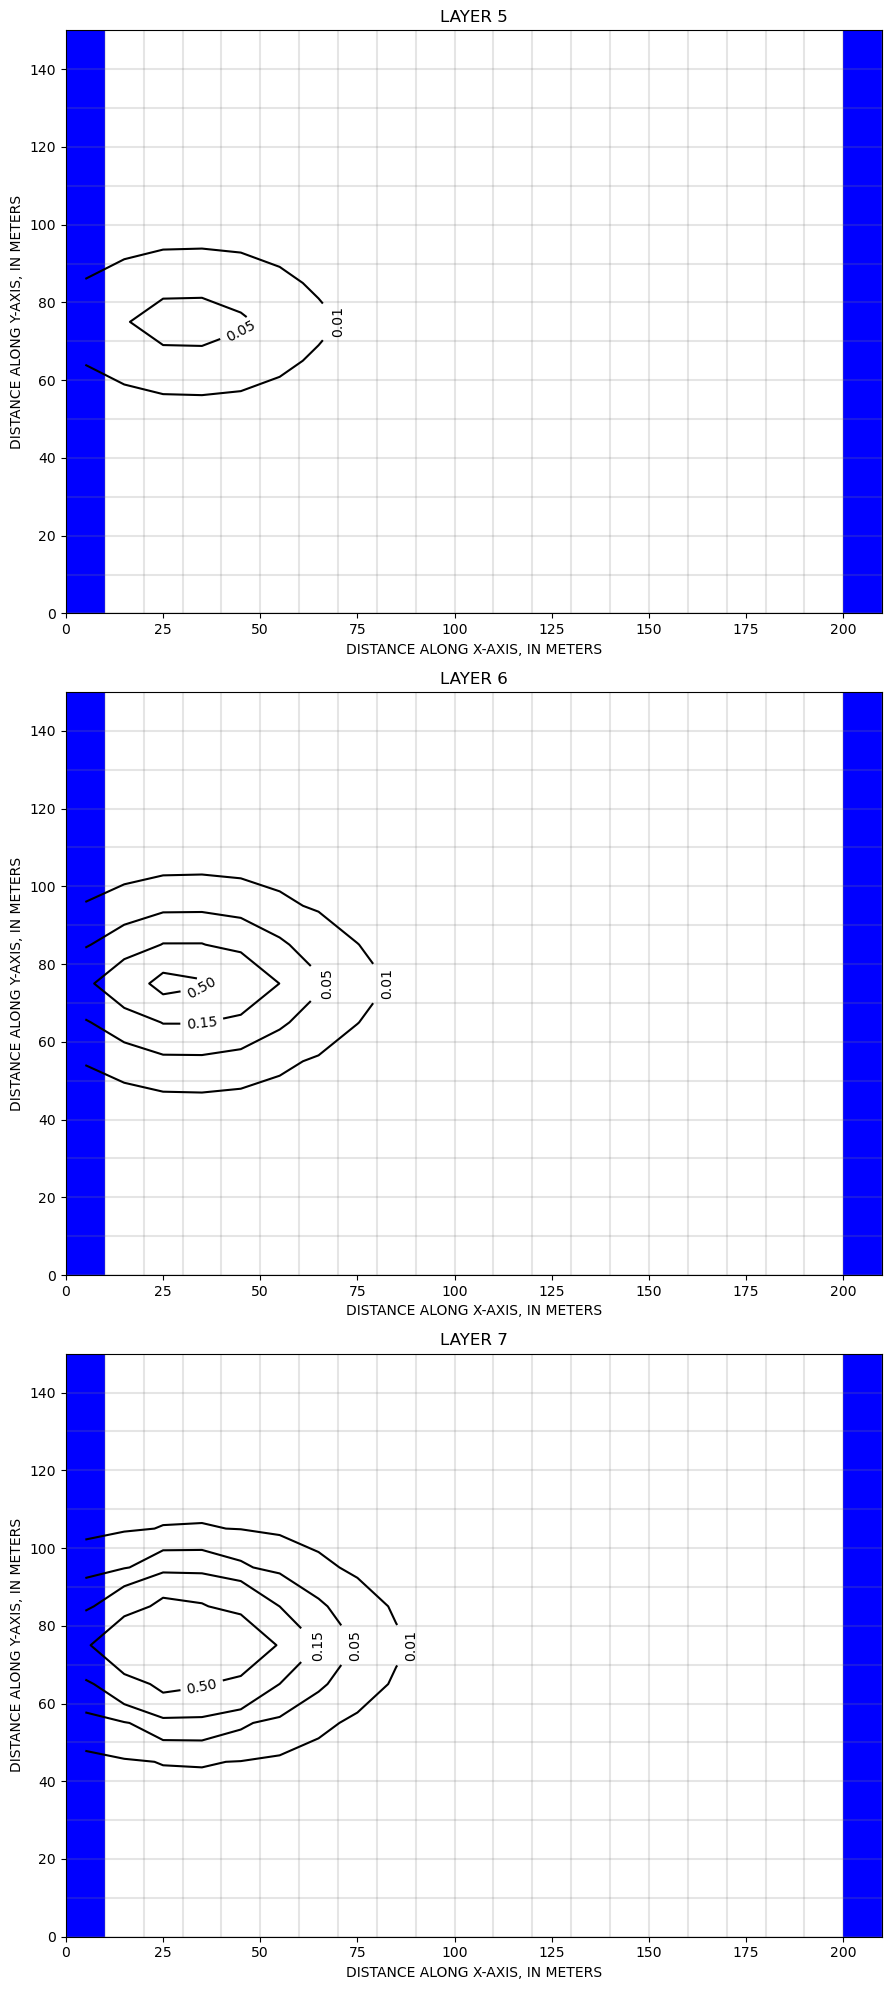

In [24]:
fig = plt.figure(figsize=(10, 20))
mf, mt, conc, cvt, mvt = p07("p07", -1)
conc = conc[0]

ax = fig.add_subplot(3, 1, 1, aspect="equal")
ilay = 4
pmv = flopy.plot.PlotMapView(ax=ax, model=mf, layer=ilay)
pmv.plot_grid(color=".5", alpha=0.2)
pmv.plot_ibound()
cs = pmv.contour_array(conc, levels=[0.01, 0.05, 0.15, 0.50], colors="k")
plt.clabel(cs)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title(f"LAYER {ilay + 1}")

ax = fig.add_subplot(3, 1, 2, aspect="equal")
ilay = 5
pmv = flopy.plot.PlotMapView(ax=ax, model=mf, layer=ilay)
pmv.plot_grid(color=".5", alpha=0.2)
pmv.plot_ibound()
cs = pmv.contour_array(conc, levels=[0.01, 0.05, 0.15, 0.50], colors="k")
plt.clabel(cs)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title(f"LAYER {ilay + 1}")

ax = fig.add_subplot(3, 1, 3, aspect="equal")
ilay = 6
pmv = flopy.plot.PlotMapView(ax=ax, model=mf, layer=ilay)
pmv.plot_grid(color=".5", alpha=0.2)
pmv.plot_ibound()
cs = pmv.contour_array(conc, levels=[0.01, 0.05, 0.15, 0.50], colors="k")
plt.clabel(cs)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title(f"LAYER {ilay + 1}")
plt.plot(grid.xcellcenters[7, 2], grid.ycellcenters[7, 2], "ko")

plt.tight_layout()

## Example 8. Two-Dimensional, Vertical Transport in a Heterogeneous Aquifer

In [25]:
def p08(dirname, mixelm):
    model_ws = os.path.join(workdir, dirname)
    nlay = 27
    nrow = 1
    ncol = 50
    delr = 5
    delc = 1
    delv = 0.25
    prsity = 0.35
    al = 0.5
    trpt = 0.01
    trpv = 0.01
    dmcoef = 1.34e-5 / 100 / 100 * 86400
    rech = 0.1 / 365  # m/d

    perlen_mf = 1
    perlen_mt = [5 * 365, 15 * 365]

    k1 = 5e-4 / 100.0 * 86400  # m/d
    k2 = 1e-2 / 100.0 * 86400  # m/d
    hk = k1 * np.ones((nlay, nrow, ncol), dtype=float)
    hk[11:19, :, 0:24] = k2
    hk[11:19, :, 36:] = k2
    laytyp = 6 * [1] + 21 * [0]

    modelname_mf = f"{dirname}_mf"
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf
    )
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=6.75,
        botm=[6.75 - delv * k for k in range(1, nlay + 1)],
        perlen=perlen_mf,
    )
    f = open(os.path.join(datadir, "p08shead.dat"))
    strt = np.empty((nlay * ncol), dtype=float)
    strt = read1d(f, strt).reshape((nlay, nrow, ncol))
    f.close()
    ibound = np.ones((nlay, nrow, ncol), dtype=int)
    ibound[5:, :, -1] = -1
    ibound[strt < 0] = 0

    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=hk, laytyp=laytyp)
    rch = flopy.modflow.ModflowRch(mf, rech=rech)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = f"{dirname}_mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=model_ws,
        exe_name=exe_name_mt,
        modflowmodel=mf,
    )
    btn = flopy.mt3d.Mt3dBtn(
        mt,
        icbund=1,
        prsity=prsity,
        sconc=0,
        nper=2,
        perlen=perlen_mt,
        timprs=[8 * 365, 12 * 365, 20 * 365],
    )
    percel = 1.0
    itrack = 3
    wd = 0.5
    dceps = 1.0e-5
    nplane = 0
    npl = 0
    nph = 10
    npmin = 2
    npmax = 20
    dchmoc = 1.0e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=percel,
        itrack=itrack,
        wd=wd,
    )
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, trpv=trpv, dmcoef=dmcoef)
    crch1 = np.zeros((nrow, ncol), dtype=float)
    crch1[0, 9:18] = 1.0
    cnc0 = [(0, 0, j, 1, -1) for j in range(8, 16)]
    cnc1 = [(0, 0, j, 0.0, -1) for j in range(8, 16)]
    ssmspd = {0: cnc0, 1: cnc1}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssmspd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)

    fname = os.path.join(model_ws, "MT3D001.UCN")
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, "MT3D001.MAS")
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

found 'rch' in modflow model, resetting crch to 0.0


Text(0.5, 1.0, 'TIME = 20 YEARS')

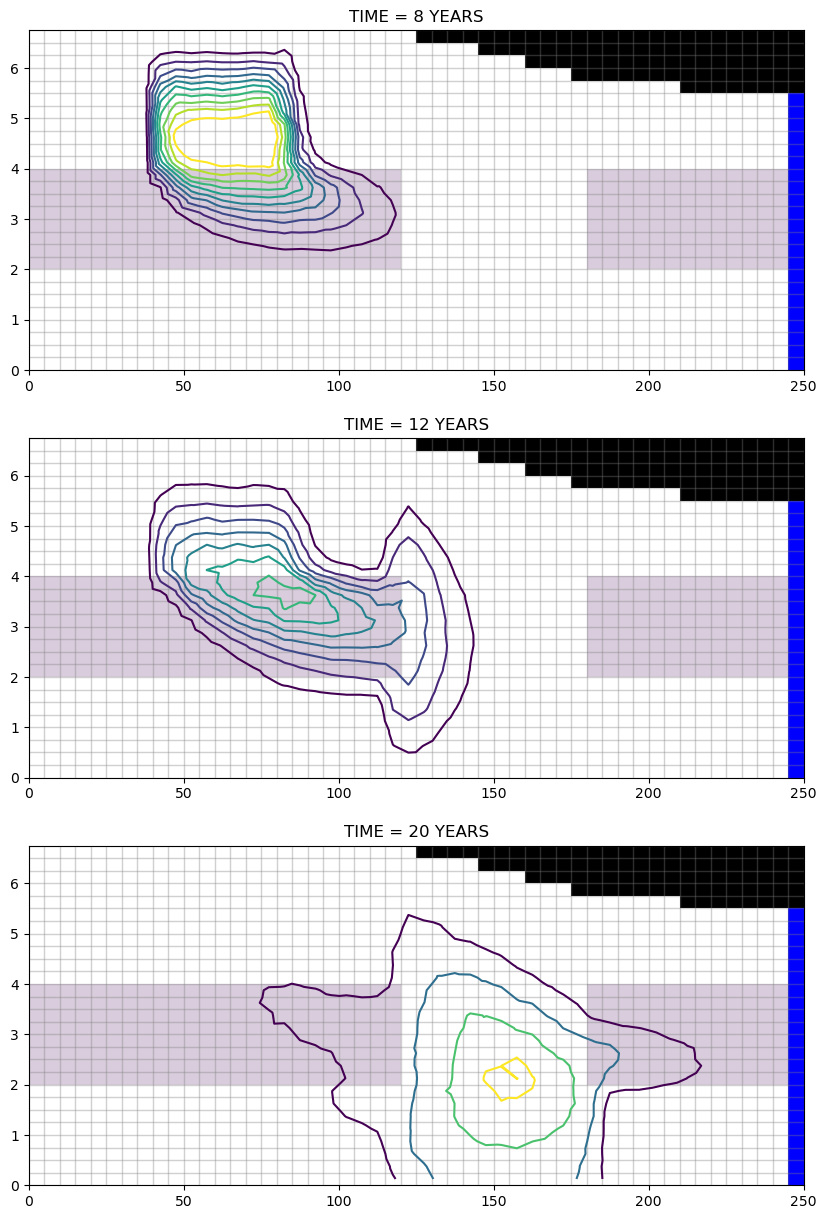

In [26]:
fig = plt.figure(figsize=(10, 15))
mf, mt, conc, cvt, mvt = p08("p08", 3)
hk = mf.lpf.hk.array

ax = fig.add_subplot(3, 1, 1)
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": 0})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
mx.plot_ibound()
mx.plot_grid(color="0.5", alpha=0.2)
cs = mx.contour_array(
    conc[1], levels=np.arange(0.05, 0.55, 0.05), masked_values=[1.0e30]
)
ax.set_title("TIME = 8 YEARS")

ax = fig.add_subplot(3, 1, 2)
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": 0})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
mx.plot_ibound()
mx.plot_grid(color="0.5", alpha=0.2)
cs = mx.contour_array(
    conc[2], levels=np.arange(0.05, 0.55, 0.05), masked_values=[1.0e30]
)
ax.set_title("TIME = 12 YEARS")

ax = fig.add_subplot(3, 1, 3)
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": 0})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
mx.plot_ibound()
mx.plot_grid(color="0.5", alpha=0.2)
cs = mx.contour_array(conc[3], levels=[0.05, 0.1, 0.15, 0.19], masked_values=[1.0e30])
ax.set_title("TIME = 20 YEARS")

## Example 9. Two-Dimensional Application Example

In [27]:
def p09(dirname, mixelm, nadvfd):
    model_ws = os.path.join(workdir, dirname)
    nlay = 1
    nrow = 18
    ncol = 14
    delr = 100
    delc = 100
    delv = 10
    prsity = 0.3
    al = 20.0
    trpt = 0.2

    perlen_mf = 1.0
    perlen_mt = [365.0 * 86400, 365.0 * 86400]
    laytyp = 0
    k1 = 1.474e-4
    k2 = 1.474e-7
    hk = k1 * np.ones((nlay, nrow, ncol), dtype=float)
    hk[:, 5:8, 1:8] = k2

    modelname_mf = f"{dirname}_mf"
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf
    )
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=0.0,
        botm=[0 - delv],
        perlen=perlen_mf,
    )
    ibound = np.ones((nlay, nrow, ncol), dtype=int)
    ibound[0, 0, :] = -1
    ibound[0, -1, :] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=float)
    strt[0, 0, :] = 250.0
    xc = mf.modelgrid.xcellcenters
    for j in range(ncol):
        strt[0, -1, j] = 20.0 + (xc[0, j] - xc[0, 0]) * 2.5 / 100
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    welspd = [[0, 3, 6, 0.001], [0, 10, 6, -0.0189]]
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    modelname_mt = f"{dirname}_mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=model_ws,
        exe_name=exe_name_mt,
        modflowmodel=mf,
    )
    btn = flopy.mt3d.Mt3dBtn(
        mt,
        icbund=1,
        prsity=prsity,
        sconc=0,
        nper=2,
        perlen=perlen_mt,
        obs=[[0, 10, 6]],
    )
    percel = 1.0
    itrack = 2
    dceps = 1.0e-5
    nplane = 0
    npl = 0
    nph = 16
    npmin = 0
    npmax = 32
    dchmoc = 1.0e-3
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=percel,
        itrack=itrack,
        nadvfd=nadvfd,
    )
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    spd = {
        0: [[0, 3, 6, 57.87, 2], [0, 10, 6, 0.0, 2]],
        1: [[0, 3, 6, 0.0, 2], [0, 10, 6, 0.0, 2]],
    }
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)

    fname = os.path.join(model_ws, "MT3D001.UCN")
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, "MT3D001.MAS")
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

Text(0.5, 1.0, 'ULTIMATE')

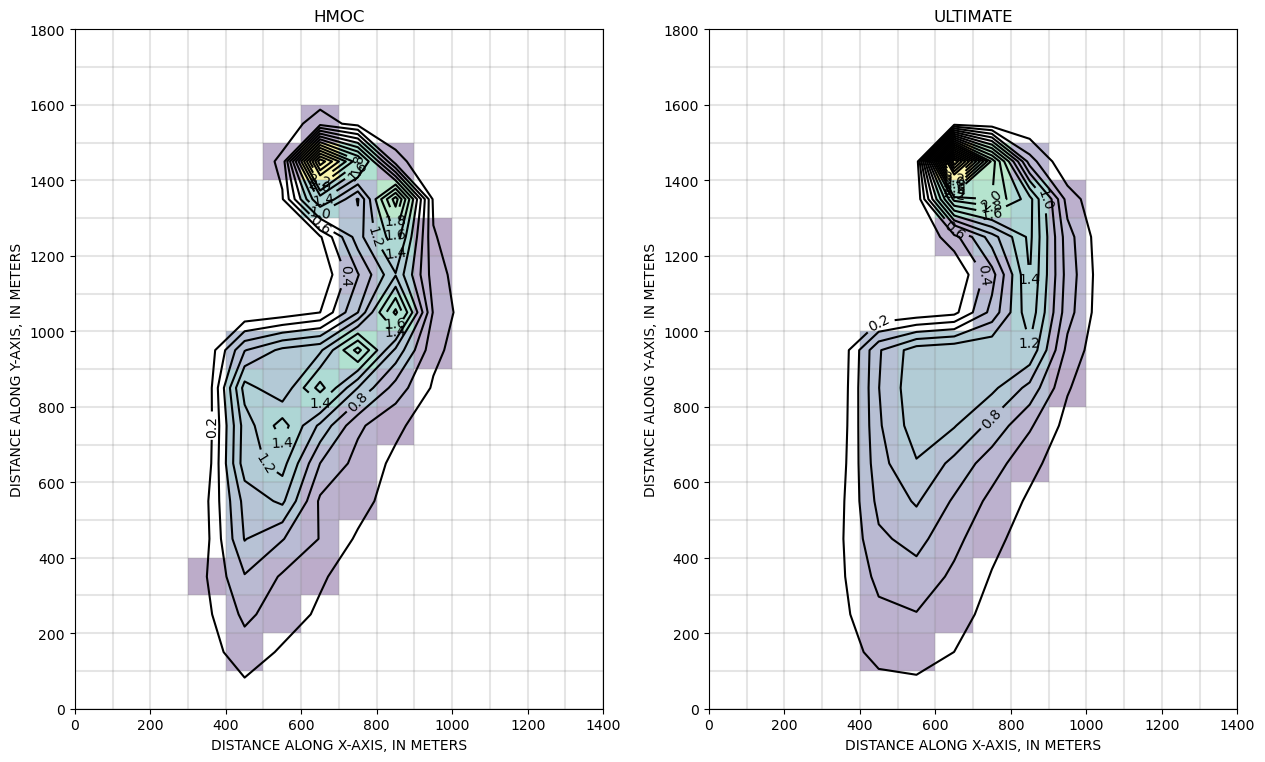

In [28]:
fig = plt.figure(figsize=(15, 10))
levels = np.arange(0.2, 10, 0.2)

ax = fig.add_subplot(1, 2, 1, aspect="equal")
mf, mt, conc, cvt, mvt = p09("p09", 3, 1)
cvt["time"] / 365.0 / 86400.0
y = cvt["(1, 11, 7)"]
conc = conc[:, 0, :, :]
cflood = np.ma.masked_less_equal(conc, 0.2)
pmv = flopy.plot.PlotMapView(ax=ax, model=mf)
pmv.plot_grid(color=".5", alpha=0.2)
cs = pmv.plot_array(cflood[0], alpha=0.2, vmin=0, vmax=3)
cs = pmv.contour_array(conc[0], colors="k", levels=levels)
plt.clabel(cs)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title("HMOC")

ax = fig.add_subplot(1, 2, 2, aspect="equal")
mf, mt, conc, cvt, mvt = p09("p09", -1, 1)
cvt["time"] / 365.0 / 86400.0
y = cvt["(1, 11, 7)"]
conc = conc[:, 0, :, :]
cflood = np.ma.masked_less_equal(conc, 0.2)
pmv = flopy.plot.PlotMapView(ax=ax, model=mf)
pmv.plot_grid(color=".5", alpha=0.2)
cs = pmv.plot_array(cflood[0], alpha=0.2, vmin=0, vmax=3)
cs = pmv.contour_array(conc[0], colors="k", levels=levels)
plt.clabel(cs)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title("ULTIMATE")

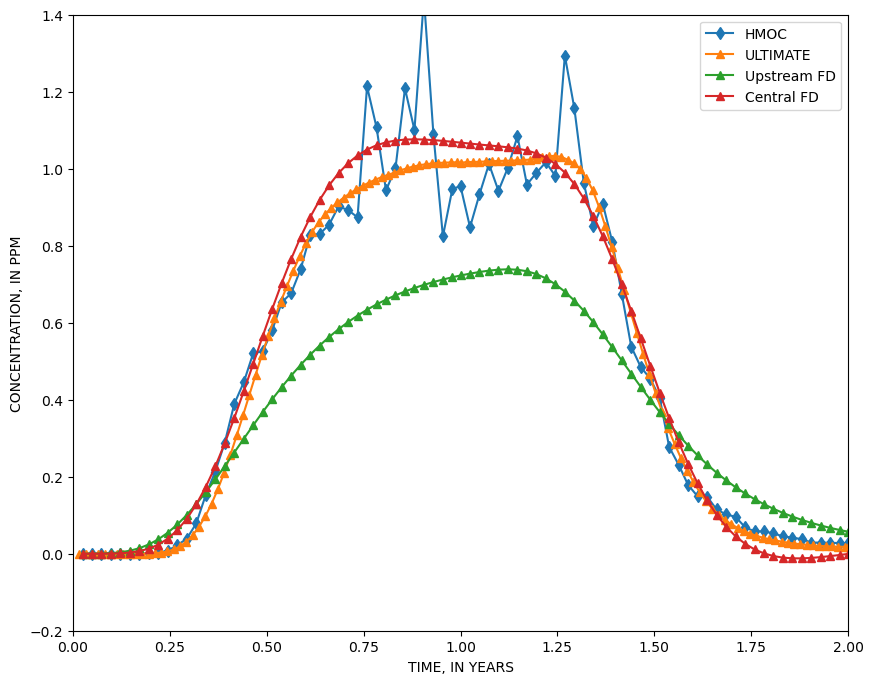

In [29]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)

mf, mt, conc, cvt, mvt = p09("p09", 3, 1)
x = cvt["time"] / 365.0 / 86400.0
y = cvt["(1, 11, 7)"]
plt.plot(x, y, label="HMOC", marker="d")

mf, mt, conc, cvt, mvt = p09("p09", -1, 1)
x = cvt["time"] / 365.0 / 86400.0
y = cvt["(1, 11, 7)"]
plt.plot(x, y, label="ULTIMATE", marker="^")

mf, mt, conc, cvt, mvt = p09("p09", 0, 1)
x = cvt["time"] / 365.0 / 86400.0
y = cvt["(1, 11, 7)"]
plt.plot(x, y, label="Upstream FD", marker="^")

mf, mt, conc, cvt, mvt = p09("p09", 0, 2)
x = cvt["time"] / 365.0 / 86400.0
y = cvt["(1, 11, 7)"]
plt.plot(x, y, label="Central FD", marker="^")

plt.xlim(0, 2)
plt.ylim(-0.2, 1.4)
plt.xlabel("TIME, IN YEARS")
plt.ylabel("CONCENTRATION, IN PPM")
plt.legend()

## Example 10. Three-Dimensional Field Case Study

In [30]:
def p10(dirname, mixelm, perlen=1000, isothm=1, sp2=0.0, ttsmult=1.2):
    model_ws = os.path.join(workdir, dirname)
    nlay = 4
    nrow = 61
    ncol = 40
    delr = (
        [2000, 1600, 800, 400, 200, 100] + 28 * [50] + [100, 200, 400, 800, 1600, 2000]
    )
    delc = (
        [2000, 2000, 2000, 1600, 800, 400, 200, 100]
        + 45 * [50]
        + [100, 200, 400, 800, 1600, 2000, 2000, 2000]
    )
    delv = 25.0
    top = 780.0
    botm = [top - delv * k for k in range(1, nlay + 1)]
    prsity = 0.3
    al = 10.0
    trpt = 0.2
    trpv = 0.2

    perlen_mf = perlen
    perlen_mt = perlen
    hk = [60.0, 60.0, 520.0, 520.0]
    vka = 0.1
    laytyp = 0

    modelname_mf = f"{dirname}_mf"
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf
    )
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        perlen=perlen_mf,
    )
    ibound = np.ones((nlay, nrow, ncol), dtype=int)

    # left side
    ibound[:, :, 0] = -1
    # right side
    ibound[:, :, -1] = -1
    # top
    ibound[:, 0, :] = -1
    # bottom
    ibound[:, -1, :] = -1

    f = open(os.path.join(datadir, "p10shead.dat"))
    s0 = np.empty((nrow * ncol), dtype=float)
    s0 = read1d(f, s0).reshape((nrow, ncol))
    f.close()
    strt = np.zeros((nlay, nrow, ncol), dtype=float)
    for k in range(nlay):
        strt[k] = s0
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, layvka=1, vka=vka, laytyp=laytyp)
    welspd = [
        [3 - 1, 11 - 1, 29 - 1, -19230.00],
        [3 - 1, 19 - 1, 26 - 1, -19230.00],
        [3 - 1, 26 - 1, 23 - 1, -19230.00],
        [3 - 1, 33 - 1, 20 - 1, -19230.00],
        [3 - 1, 40 - 1, 17 - 1, -19230.00],
        [3 - 1, 48 - 1, 14 - 1, -19230.00],
        [3 - 1, 48 - 1, 9 - 1, -15384.00],
        [3 - 1, 52 - 1, 17 - 1, -17307.00],
    ]
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    rch = flopy.modflow.ModflowRch(mf, rech=1.14e-3)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mf.run_model(silent=True)

    modelname_mt = f"{dirname}_mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=model_ws,
        exe_name=exe_name_mt,
        modflowmodel=mf,
    )
    f = open(os.path.join(datadir, "p10cinit.dat"))
    c0 = np.empty((nrow * ncol), dtype=float)
    c0 = read1d(f, c0).reshape((nrow, ncol))
    f.close()
    sconc = np.zeros((nlay, nrow, ncol), dtype=float)
    sconc[1] = 0.2 * c0
    sconc[2] = c0
    obs = [
        [3 - 1, 11 - 1, 29 - 1],
        [3 - 1, 19 - 1, 26 - 1],
        [3 - 1, 26 - 1, 23 - 1],
        [3 - 1, 33 - 1, 20 - 1],
        [3 - 1, 40 - 1, 17 - 1],
        [3 - 1, 48 - 1, 14 - 1],
        [3 - 1, 48 - 1, 9 - 1],
        [3 - 1, 52 - 1, 17 - 1],
    ]
    btn = flopy.mt3d.Mt3dBtn(
        mt,
        icbund=1,
        prsity=prsity,
        sconc=sconc,
        timprs=[500, 750, 1000],
        dt0=2.25,
        ttsmult=ttsmult,
        obs=obs,
    )
    dceps = 1.0e-5
    nplane = 0
    npl = 0
    nph = 16
    npmin = 2
    npmax = 32
    dchmoc = 0.01
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=1.0,
    )
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, trpv=trpv)
    ssm = flopy.mt3d.Mt3dSsm(mt, crch=0.0)
    rct = flopy.mt3d.Mt3dRct(mt, isothm=isothm, igetsc=0, rhob=1.7, sp1=0.176, sp2=sp2)
    mxiter = 1
    if isothm == 4:
        mxiter = 50
    gcg = flopy.mt3d.Mt3dGcg(mt, mxiter=mxiter, iter1=500)
    mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)

    fname = os.path.join(model_ws, "MT3D001.UCN")
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, "MT3D001.MAS")
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

In [31]:
mf, mt, conctvd, cvttvd, mvttvd = p10("p10", -1)
mf, mt, conchmoc, cvthmoc, mvthmoc = p10("p10", 3)
mf, mt, concupfd, cvtupfd, mvtupfd = p10("p10", 0, ttsmult=1.0)
grid = mf.modelgrid

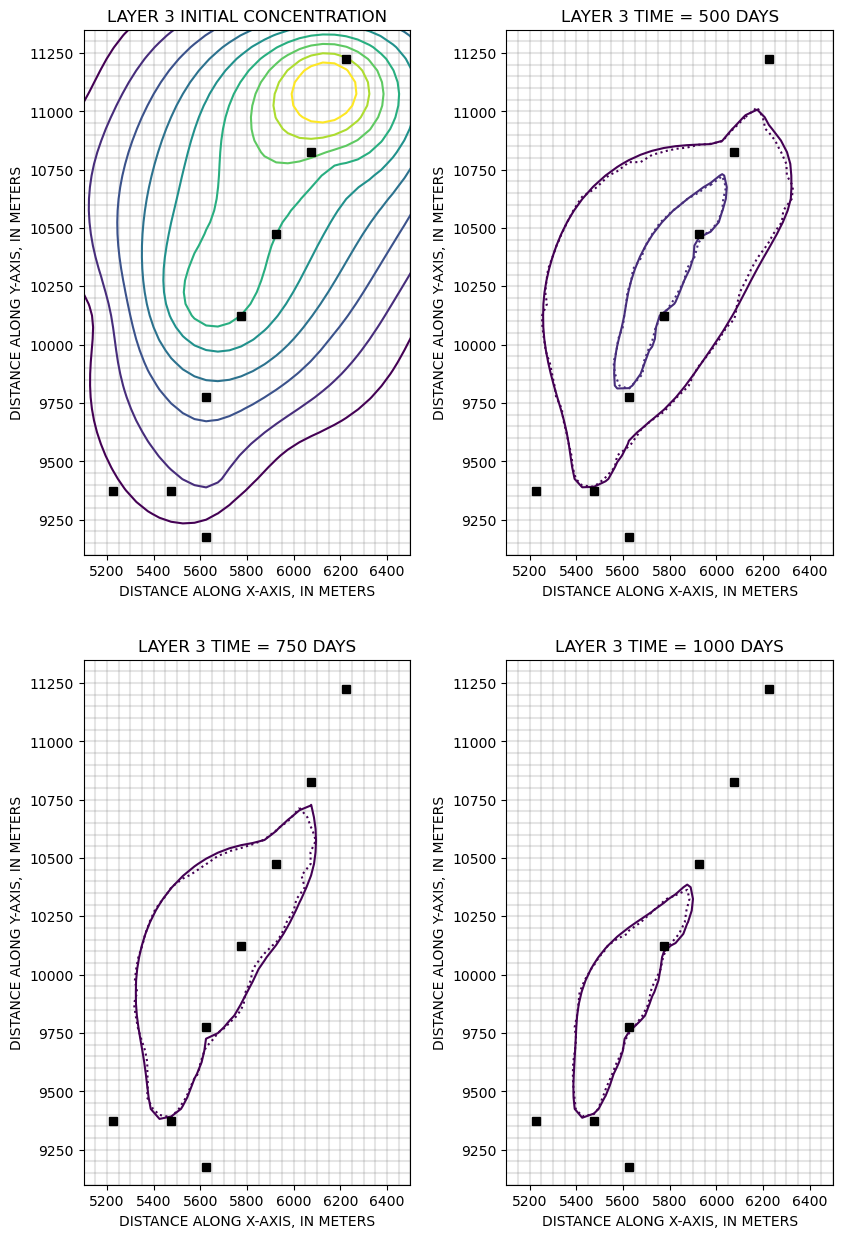

In [32]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(2, 2, 1, aspect="equal")
cinit = mt.btn.sconc[0].array[2]
pmv = flopy.plot.PlotMapView(model=mf)
pmv.plot_grid(color=".5", alpha=0.2)
cs = pmv.contour_array(cinit, levels=np.arange(20, 200, 20))
plt.xlim(5100, 5100 + 28 * 50)
plt.ylim(9100, 9100 + 45 * 50)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title(f"LAYER {3} INITIAL CONCENTRATION")
for k, i, j, q in mf.wel.stress_period_data[0]:
    plt.plot(grid.xcellcenters[i, j], grid.ycellcenters[i, j], "ks")

ax = fig.add_subplot(2, 2, 2, aspect="equal")
c = conctvd[0, 2]
chmoc = conchmoc[0, 2]
pmv = flopy.plot.PlotMapView(model=mf)
pmv.plot_grid(color=".5", alpha=0.2)
cs = pmv.contour_array(c, levels=np.arange(20, 200, 20))
cs = pmv.contour_array(chmoc, linestyles=":", levels=np.arange(20, 200, 20))
plt.xlim(5100, 5100 + 28 * 50)
plt.ylim(9100, 9100 + 45 * 50)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title(f"LAYER {3} TIME = 500 DAYS")
for k, i, j, q in mf.wel.stress_period_data[0]:
    plt.plot(grid.xcellcenters[i, j], grid.ycellcenters[i, j], "ks")

ax = fig.add_subplot(2, 2, 3, aspect="equal")
c = conctvd[1, 2]
chmoc = conchmoc[1, 2]
pmv = flopy.plot.PlotMapView(model=mf)
pmv.plot_grid(color=".5", alpha=0.2)
cs = pmv.contour_array(c, levels=np.arange(20, 200, 20))
cs = pmv.contour_array(chmoc, linestyles=":", levels=np.arange(20, 200, 20))
plt.xlim(5100, 5100 + 28 * 50)
plt.ylim(9100, 9100 + 45 * 50)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title(f"LAYER {3} TIME = 750 DAYS")
for k, i, j, q in mf.wel.stress_period_data[0]:
    plt.plot(grid.xcellcenters[i, j], grid.ycellcenters[i, j], "ks")

ax = fig.add_subplot(2, 2, 4, aspect="equal")
c = conctvd[2, 2]
chmoc = conchmoc[2, 2]
pmv = flopy.plot.PlotMapView(model=mf)
pmv.plot_grid(color=".5", alpha=0.2)
cs = pmv.contour_array(c, levels=np.arange(20, 200, 20))
cs = pmv.contour_array(chmoc, linestyles=":", levels=np.arange(20, 200, 20))
plt.xlim(5100, 5100 + 28 * 50)
plt.ylim(9100, 9100 + 45 * 50)
plt.xlabel("DISTANCE ALONG X-AXIS, IN METERS")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN METERS")
plt.title(f"LAYER {3} TIME = 1000 DAYS")
for k, i, j, q in mf.wel.stress_period_data[0]:
    plt.plot(grid.xcellcenters[i, j], grid.ycellcenters[i, j], "ks")

# plt.tight_layout()

Text(0, 0.5, 'CONCENTRATION, IN PPB')

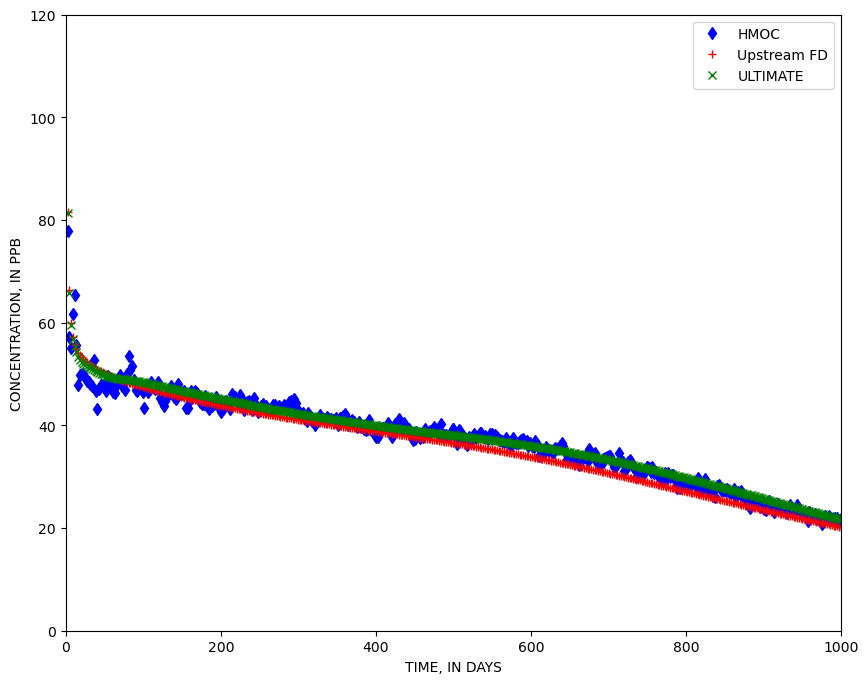

In [33]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
w4 = "(3, 33, 20)"
ax.plot(cvthmoc["time"], cvthmoc[w4], "bd", label="HMOC")
ax.plot(cvtupfd["time"], cvtupfd[w4], "r+", label="Upstream FD")
ax.plot(cvttvd["time"], cvttvd[w4], "gx", label="ULTIMATE")
plt.xlim(0, 1000)
plt.ylim(0, 120)
plt.legend()
plt.xlabel("TIME, IN DAYS")
plt.ylabel("CONCENTRATION, IN PPB")

In [34]:
mf, mt, conctvd, cvttvd, mvt0 = p10("p10", 0, perlen=2000, isothm=0)
mf, mt, conctvd, cvttvd, mvt1 = p10("p10", 0, perlen=2000, isothm=1)
mf, mt, conctvd, cvttvd, mvt2 = p10("p10", 0, perlen=2000, isothm=4, sp2=0.1)
mf, mt, conctvd, cvttvd, mvt3 = p10("p10", 0, perlen=2000, isothm=4, sp2=1.5e-4)
mf, mt, conctvd, cvttvd, mvt4 = p10("p10", 0, perlen=2000, isothm=4, sp2=1.0e-6)

Text(0, 0.5, 'TOTAL MASS REMOVED')

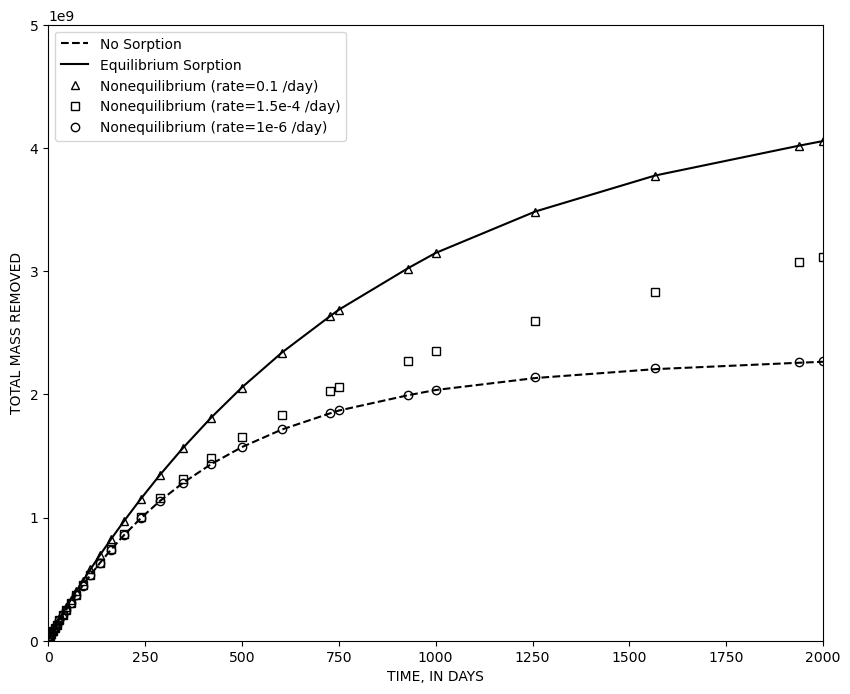

In [35]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(mvt0["time"], -mvt0["sinks"], "k--", label="No Sorption")
ax.plot(mvt1["time"], -mvt1["sinks"], "k-", label="Equilibrium Sorption")
ax.plot(
    mvt2["time"],
    -mvt2["sinks"],
    "k^",
    fillstyle="none",
    label="Nonequilibrium (rate=0.1 /day)",
)
ax.plot(
    mvt3["time"],
    -mvt3["sinks"],
    "ks",
    fillstyle="none",
    label="Nonequilibrium (rate=1.5e-4 /day)",
)
ax.plot(
    mvt4["time"],
    -mvt4["sinks"],
    "ko",
    fillstyle="none",
    label="Nonequilibrium (rate=1e-6 /day)",
)
plt.xlim(0, 2000)
plt.ylim(0, 5e9)
plt.legend(loc=2)
plt.xlabel("TIME, IN DAYS")
plt.ylabel("TOTAL MASS REMOVED")

In [36]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass